# integrated_gradients 2

In [3]:
from typing import List, Dict, Any, Tuple, Optional, Union
from pathlib import Path
import numpy as np 
import xarray as xr 
import pandas as pd
import pickle 
import random
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns


import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)
from neuralhydrology.datasetzoo import PixelDataset
from neuralhydrology.datautils.utils import load_basin_file
from neuralhydrology.datasetzoo import CamelsGB
from scripts.read_model import (get_model, _load_weights)
from neuralhydrology.utils.config import Config

# Load Model, Config and Data

In [4]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

data_dir = Path("/datadrive/data")
st_data_dir = Path("/home/tommy/spatio_temporal/data")
points = load_latlon_points(st_data_dir)
static = xr.open_dataset(st_data_dir / "camels_static.nc")

In [5]:
run_dir = Path("/datadrive/data/runs/cwatm_azure_with_static_1990_2000_ORIGINAL_DATALOADER_2207_093806")

# load config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

# load model
device = cfg.device
model = get_model(cfg).to(device)
_load_weights(model, cfg)

Using the model weights from /datadrive/data/runs/cwatm_azure_with_static_1990_2000_ORIGINAL_DATALOADER_2207_093806/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(24, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [6]:
ds = xr.open_dataset(Path("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc"))

res_fp = get_test_filepath(run_dir, epoch=30)
preds = get_all_station_ds(res_fp)

100%|██████████| 669/669 [00:00<00:00, 1997.04it/s]


# load Integrated gradients

In [9]:
from scripts.integrated_gradients import create_gradient_xarray
from scripts.cell_state.timeseries_model import _round_time_to_hour
from tqdm import tqdm


In [380]:
if "gradients" not in globals().keys():
    gradients = create_gradient_xarray(cfg, run_dir)
    gradients["station_id"] = gradients["station_id"].astype(int)

    # assign time to gradients
    if not (data_dir / "gradients_time.nc").exists():
        actual_time = gradients.target_time - gradients.seq_length
        gradients = gradients.assign_coords(time=actual_time)
        for seq_ix in tqdm(np.arange(gradients["time"].shape[-1])):    
            gradients["time"].values[:, seq_ix] = _round_time_to_hour(gradients["time"].values[:, seq_ix])
    else:
        actual_time = xr.open_dataset(data_dir / "gradients_time.nc")
        gradients = gradients.assign_coords(time=actual_time.to_array().isel(variable=0))
    gradients = gradients.sortby("seq_length", ascending=False)

In [381]:
g = gradients.copy()
gradients

<xarray.Dataset>
Dimensions:        (seq_length: 365, station_id: 535, target_time: 3652)
Coordinates:
  * station_id     (station_id) int64 10003 1001 101002 ... 67001 67005 67006
  * target_time    (target_time) datetime64[ns] 2001-01-01 ... 2010-12-31
  * seq_length     (seq_length) int64 364 363 362 361 360 359 ... 5 4 3 2 1 0
    variable       <U29 '__xarray_dataarray_variable__'
    time           (target_time, seq_length) datetime64[ns] 2001-01-01 ... 20...
Data variables:
    Precipitation  (station_id, target_time, seq_length) float64 6.479e-05 .....
    Tavg           (station_id, target_time, seq_length) float64 -0.001793 .....

# contribution of input features

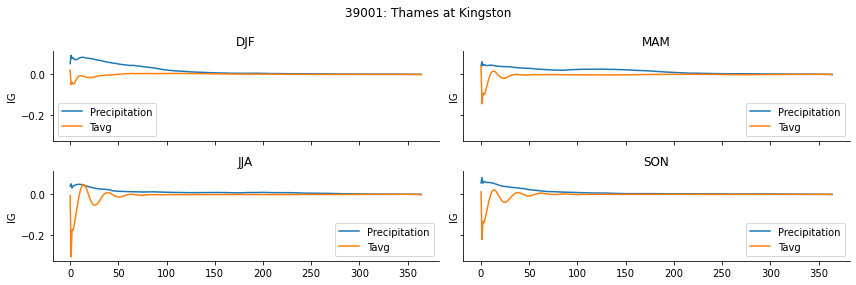

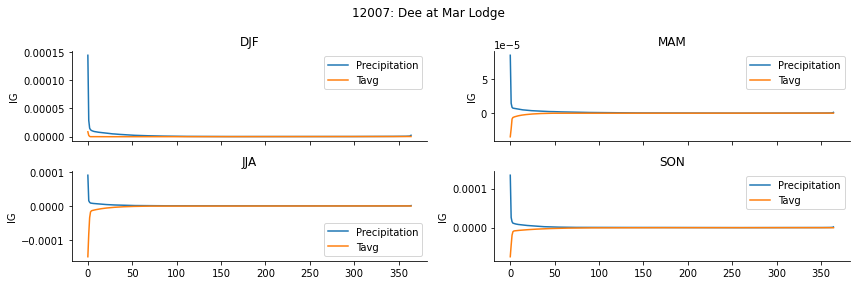

In [428]:
def plot_season_mean_IG(
    gradients: xr.Dataset, 
    twinx: bool = False, 
    var1: str = "Precipitation", 
    var2: str = "Tavg", 
    absolute: bool = True,
    sharey: bool = False,
):
    assert gradients["station_id"].size == 1
    sid = int(gradients['station_id'])
    season = gradients.groupby("target_time.season").mean()
    f, axs = plt.subplots(2, 2, figsize=(6*2, 2*2), sharey=sharey, sharex=True, tight_layout=True)

    for ix, seas in enumerate(["DJF", "MAM", "JJA", "SON"]):
        g = season.sel(season=seas)
        ax = axs[np.unravel_index(ix, (2, 2))]
        
        data1 = abs(g[var1]) if absolute else g[var1]
        data2 = abs(g[var2]) if absolute else g[var2]
        ax.plot(g.seq_length, data1, label=var1, color="C0")
        if twinx:
            ax2 = ax.twinx()
        else:
            ax2 = ax
        ax2.plot(g.seq_length, data2, label=var2, color="C1")

        ax.legend()
        ax.set_title(seas)
        ax.set_ylabel("IG")
        sns.despine()
    f.suptitle(f"{sid}: {str(static.sel(station_id=sid)['gauge_name'].values)}")
        

big_sid = int(static.where(static["area"] == static["area"].max(), drop=True).station_id.values)
snow_sid = int(static.where(static["frac_snow"]==static["frac_snow"].max(), drop=True).station_id.values)

plot_season_mean_IG(gradients.sel(station_id=big_sid), absolute=False, sharey=True)
plot_season_mean_IG(gradients.sel(station_id=snow_sid), absolute=False)

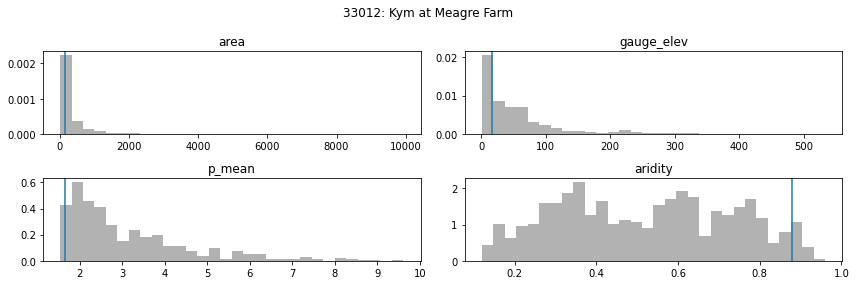

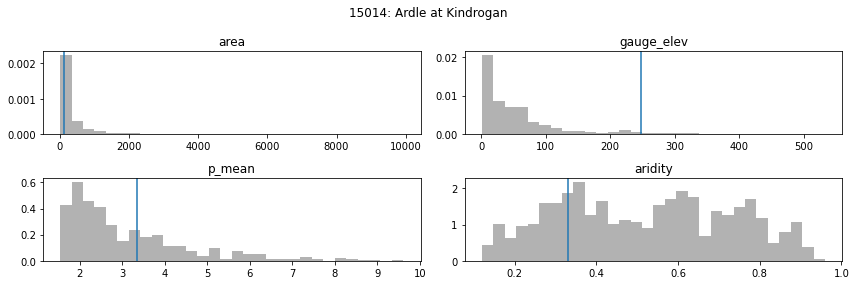

In [506]:
def plot_context(sid: int, variables: List[str] = ["area", "gauge_elev", "p_mean", "aridity"], spatial: bool = False):
    f, axs = plt.subplots(2,2, figsize=(12, 4), tight_layout=True)

    for ix, var_ in enumerate(variables):
        ax = axs[np.unravel_index(ix, (2, 2))]
        ax.hist(static[var_], color="grey", alpha=0.6, bins=30, density=True)
        ax.axvline(static[var_].sel(station_id=sid))
        ax.set_title(var_)

    name = str(static.sel(station_id=sid)['gauge_name'].values)
    f.suptitle(f"{sid}: {name}");
    
    if spatial:
        ax = initialise_gb_spatial_plot()
        points.plot(color="grey", alpha=0.6, markersize=4, ax=ax)
        points.loc[[sid]].plot(ax=ax, markersize=100)
    

area_thresh = static["area"].quantile(q=0.3).values
big_static = static.where(static["area"] >= area_thresh)

agr_sid = int(big_static.where(big_static["crop_perc"] == big_static["crop_perc"].max(), drop=True).station_id.values)
shr_sid = int(big_static.where(big_static["shrub_perc"] == big_static["shrub_perc"].max(), drop=True).station_id.values)
clay_sid = int(big_static.where(big_static["clay_perc"] == big_static["clay_perc"].max(), drop=True).station_id.values)
sand_sid = int(big_static.where(big_static["sand_perc"] == big_static["sand_perc"].max(), drop=True).station_id.values)

# plot_context(snow_sid)
# plot_context(big_sid)
# plot_context(agr_sid, spatial=True)
# plot_context(shr_sid, spatial=True)
plot_context(clay_sid, spatial=False)
plot_context(sand_sid, spatial=False)
# print(big_static["clay_perc"].max())
# print(big_static["sand_perc"].max())

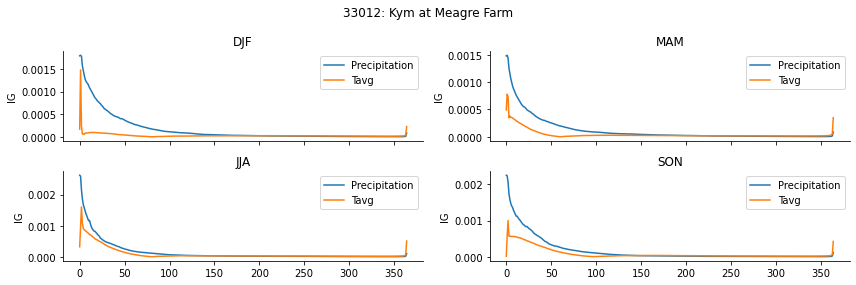

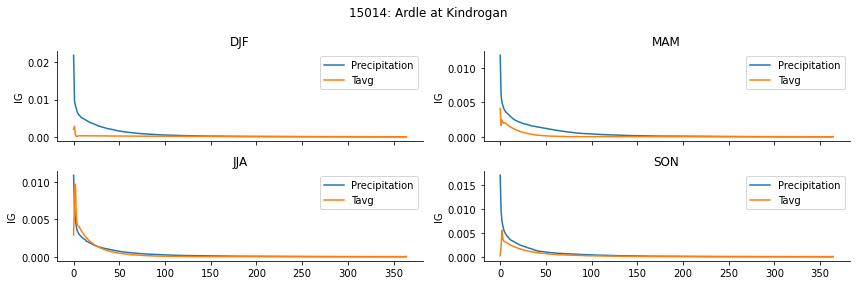

In [499]:
# plot_season_mean_IG(gradients.sel(station_id=agr_sid, seq_length=slice(100, 0)), absolute=False, sharey=True, twinx=False)
# plot_season_mean_IG(gradients.sel(station_id=shr_sid, seq_length=slice(100, 0)), absolute=False, sharey=True, twinx=False)

plot_season_mean_IG(gradients.sel(station_id=clay_sid), absolute=True, sharey=False)
plot_season_mean_IG(gradients.sel(station_id=sand_sid), absolute=True, sharey=False)

In [500]:
print([v for v in static.data_vars if "perc" in v])

# Time Steps of Interest (how many timesteps contribute to output?)

In [345]:
def calculate_tsoi(gradients: xr.Dataset, thresh: float = 2e-3):
    """https://arxiv.org/pdf/1903.07903.pdf
    """
    assert all(np.isin(["seq_length"], [v for v in gradients.coords]))

# 1) sum the integrated gradients across the features for each time step
summed = gradients.to_array().sum(dim="variable")

# 2) calculate the difference from time step to time step
diffed = summed.diff(dim="seq_length")

# 3) determine the first timestep t, at which the difference surpasses a threshold of []
#     remove the last years information (350+)
subset_diffed = diffed.sel(seq_length=slice(350, 0))
threshold_diff_mask = (abs(subset_diffed) > thresh)
first_tstep_mask = threshold_diff_mask.cumsum(dim="seq_length") == 1
first_timesteps = first_tstep_mask.argmax(dim="seq_length")

# 4) calculate the number of Time Steps Of Influence (TSOI) 
#  with T being the total length of the sequence
T = diffed["seq_length"].size
TSOI = T - first_timesteps
    
#     # [station_id, target_time]
#     return TSOI


# g = gradients.sel(station_id=np.random.choice(gradients.station_id.values))
# # if "TSOI" not in globals().keys():
# TSOI = calculate_tsoi(gradients, thresh=9e-3)
doy_tsoi = TSOI.groupby("target_time.dayofyear").median()

Text(0, 0.5, 'TSOI')

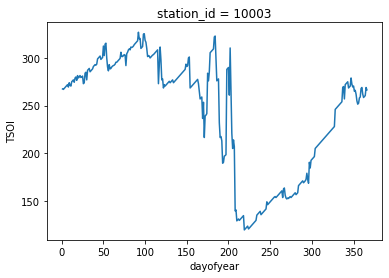

In [346]:
doy_tsoi.isel(station_id=0).plot()
plt.gca().set_ylabel("TSOI")

In [337]:
# threshold_diff_mask.isel(target_time=slice(0, 10)).plot(col="target_time", col_wrap=2)

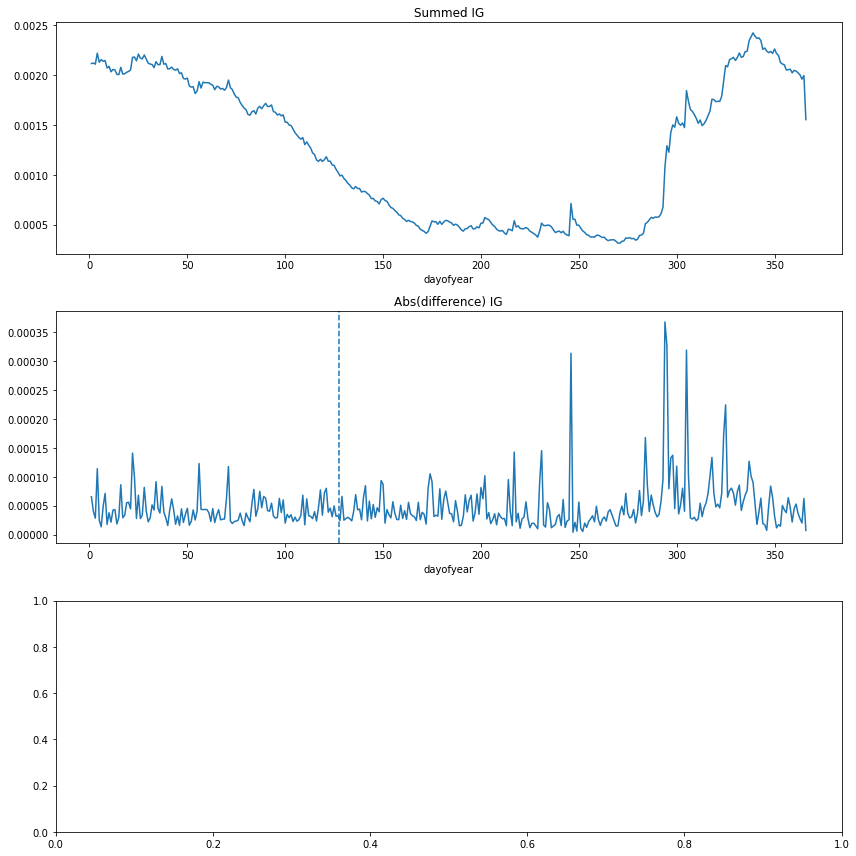

In [338]:
f, axs = plt.subplots(3, 1, figsize=(12, 4*3), tight_layout=True)
g = gradients.isel(station_id=0)
summed = g.to_array().sum(dim="variable")
diffed = summed.diff(dim="seq_length")
subset_diffed = diffed.sel(seq_length=slice(350, 0))
threshold_diff_mask = (abs(subset_diffed) > thresh)
first_tstep_mask = threshold_diff_mask.cumsum(dim="seq_length") == 1
first_timesteps = first_tstep_mask.argmax(dim="seq_length")

ax = axs[0]
summed.mean(dim="seq_length").groupby("target_time.dayofyear").mean().plot(ax=ax)
ax.set_title("Summed IG")

ax = axs[1]
diffed.mean(dim="seq_length").groupby("target_time.dayofyear").mean().plot(ax=ax)
ax.axvline(first_timesteps.mean(dim="target_time"), ls="--", label="Threshold Reached")
ax.set_title("Abs(difference) IG")

ax = axs[2]


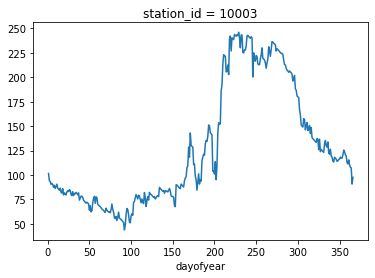

In [339]:
tsoi = doy_tsoi.isel(station_id=0)
tsoi.plot()

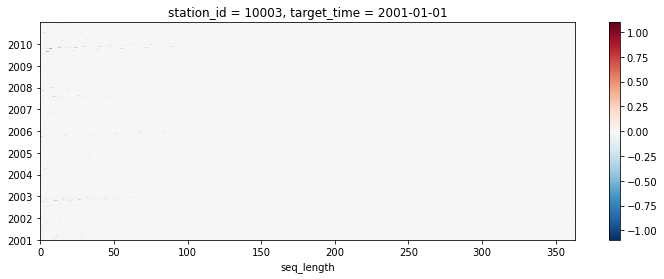

In [340]:
f, ax = plt.subplots(figsize=(12, 4))
diffed.plot()
diff2.plot()

# Snowy catchment vs. non-snowy catchments

In [272]:
snowy_sids = static.sel(station_id=static["frac_snow"] > 0.05).station_id
snow = time.sel(station_id=np.isin(time.station_id, snowy_sids))
nosnow = time.sel(station_id=~np.isin(time.station_id, snowy_sids))
nonsnowy_sids = nosnow.station_id
snowy_sids = snow.station_id

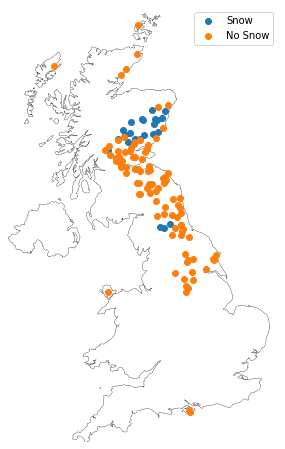

In [273]:
gdf = gpd.GeoDataFrame(snow.station_id.to_dataframe().join(points))
ns_gdf = gpd.GeoDataFrame(nosnow.station_id.to_dataframe().join(points))
ax = initialise_gb_spatial_plot()
gdf.plot(ax=ax, label="Snow")
ns_gdf.plot(ax=ax, color="C1", label="No Snow")
ax.legend()

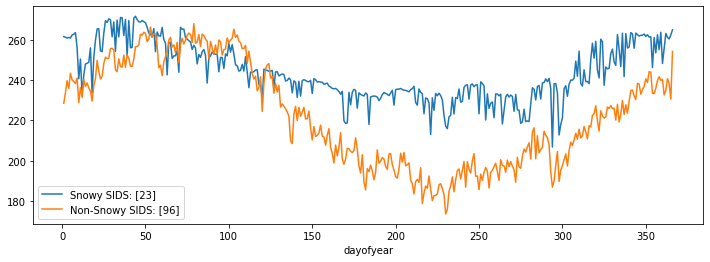

In [358]:
f, ax = plt.subplots(figsize=(12, 4))
doy_tsoi.sel(station_id=snowy_sids).mean(dim="station_id").plot(label=f"Snowy SIDS: [{len(snowy_sids)}]")
doy_tsoi.sel(station_id=nonsnowy_sids).mean(dim="station_id").plot(label=f"Non-Snowy SIDS: [{len(nonsnowy_sids)}]")
plt.legend()

In [283]:
mean_ig = gradients.to_array().sum("variable").mean(dim=["station_id", "target_time"])

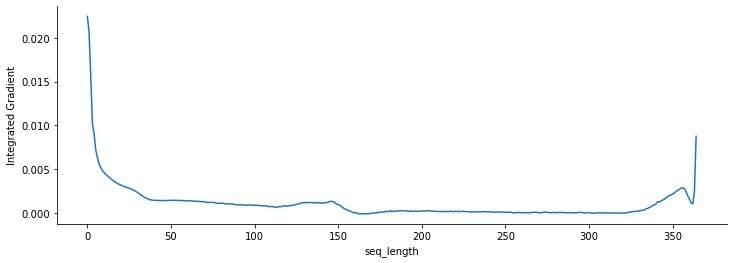

In [289]:
f, ax = plt.subplots(figsize=(12, 4))

mean_ig.plot()
ax.set_ylabel("Integrated Gradient")
sns.despine()

In [293]:
mean_diff = diffed.mean(dim=["station_id", "target_time"])

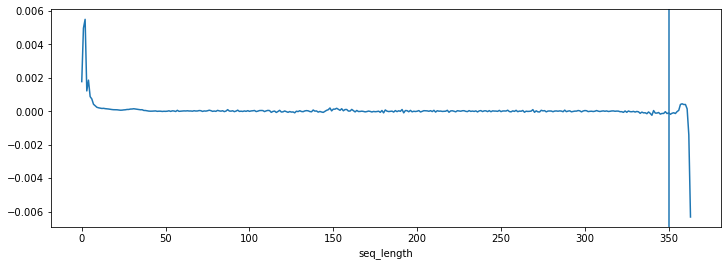

In [296]:
f, ax = plt.subplots(figsize=(12, 4))

mean_diff.plot()
ax.axvline(350)